# Assessing network performance

**Author:** Amanda M. Thomas  
**Goal:** This notebook computes some metrics commonly used to assess network performance.

---

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary
import matplotlib.pyplot as plt
import numpy as np
import time
import seisbench.data as sbd
import seisbench.models as sbm
from torch.utils.data import random_split, DataLoader
import seisbench.generate as sbg
import pandas as pd
from scipy.signal import find_peaks
from obspy import Trace, Stream

# Set seeds
np.random.seed(42)
torch.manual_seed(42)

## 1. Load the U-Net Architecture

We need to first load in the network architecture.

In [5]:
# Cell 2: U-Net Building Blocks
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, padding=1):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv1d(in_channels, out_channels, kernel_size, padding=padding),
            nn.ReLU(),
            nn.Conv1d(out_channels, out_channels, kernel_size, padding=padding),
            nn.ReLU()
        )

    def forward(self, x):
        return self.conv(x)

class UNet1D(nn.Module):
    def __init__(self, in_channels=3, out_channels=3, features=[16, 32, 64, 128]):
        super().__init__()
        
        self.downs = nn.ModuleList()  # Encoder blocks (downsampling path)
        self.ups = nn.ModuleList()    # Decoder blocks (upsampling path)
    
        # ----- Encoder: Downsampling Path -----
        # Each ConvBlock halves the temporal resolution via pooling (done in forward),
        # and increases the number of feature channels.
        for feat in features:
            self.downs.append(ConvBlock(in_channels, feat))  # ConvBlock: Conv + ReLU + Conv + ReLU
            in_channels = feat  # Update in_channels for the next block
    
        # ----- Bottleneck -----
        # Deepest layer in the U-Net, connects encoder and decoder
        self.bottleneck = ConvBlock(features[-1], features[-1]*2)
    
        # ----- Decoder: Upsampling Path -----
        # Reverse features list for symmetrical decoder
        rev_feats = features[::-1]
        for feat in rev_feats:
            # First upsample (via transposed convolution)
            self.ups.append(
                nn.ConvTranspose1d(feat*2, feat, kernel_size=2, stride=2)
            )
            # Then apply ConvBlock: input has double channels due to skip connection
            self.ups.append(ConvBlock(feat*2, feat))
    
        # ----- Final Output Convolution -----
        # 1x1 convolution to map to desired output channels (e.g., P, S, noise)
        self.final_conv = nn.Conv1d(features[0], out_channels, kernel_size=1)

    def forward(self, x):
        skip_connections = []

        for down in self.downs:
            x = down(x)
            skip_connections.append(x)
            x = F.max_pool1d(x, kernel_size=2)

        x = self.bottleneck(x)
        skip_connections = skip_connections[::-1]

        for idx in range(0, len(self.ups), 2):
            x = self.ups[idx](x)
            skip_conn = skip_connections[idx//2]
            if x.shape[-1] != skip_conn.shape[-1]:
                x = F.pad(x, (0, skip_conn.shape[-1] - x.shape[-1]))
            x = torch.cat((skip_conn, x), dim=1)
            x = self.ups[idx+1](x)
        x = self.final_conv(x)
        return F.softmax(x, dim=1)

We then intialize the model and load in the model weights.

In [6]:
model = UNet1D()

# This cell loads the saved weights into the model.
model.load_state_dict(torch.load("../Loic/UNet/model_weights_eq_only_v2.pt",weights_only=True, map_location=torch.device('cpu')))
model.eval() 

UNet1D(
  (downs): ModuleList(
    (0): ConvBlock(
      (conv): Sequential(
        (0): Conv1d(3, 16, kernel_size=(3,), stride=(1,), padding=(1,))
        (1): ReLU()
        (2): Conv1d(16, 16, kernel_size=(3,), stride=(1,), padding=(1,))
        (3): ReLU()
      )
    )
    (1): ConvBlock(
      (conv): Sequential(
        (0): Conv1d(16, 32, kernel_size=(3,), stride=(1,), padding=(1,))
        (1): ReLU()
        (2): Conv1d(32, 32, kernel_size=(3,), stride=(1,), padding=(1,))
        (3): ReLU()
      )
    )
    (2): ConvBlock(
      (conv): Sequential(
        (0): Conv1d(32, 64, kernel_size=(3,), stride=(1,), padding=(1,))
        (1): ReLU()
        (2): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,))
        (3): ReLU()
      )
    )
    (3): ConvBlock(
      (conv): Sequential(
        (0): Conv1d(64, 128, kernel_size=(3,), stride=(1,), padding=(1,))
        (1): ReLU()
        (2): Conv1d(128, 128, kernel_size=(3,), stride=(1,), padding=(1,))
        (3): ReLU

# 2. Load the dataset from the current directory

Loads the "meso" PNW dataset.

In [ ]:
#data = sbd.WaveformDataset("../data/waveform_dataset/", component_order="ENZ")
data = sbd.WaveformDataset("../../../shared/shortcourses/crescent_ml_2025/miniseed/", component_order="ENZ")
data._metadata = data.metadata[data.metadata.source_type == "earthquake"].reset_index(drop=True)
print(data.metadata["source_type"].value_counts())

2025-05-09 22:15:33,007 | seisbench | WARNING | Dimension order not specified in data set. Assuming CW.


source_type
earthquake    17960
Name: count, dtype: int64


Define the test dataset and the labels.

In [8]:
test = data.test()

phase_dict = {"trace_P_arrival_sample": "P",
              "trace_S_arrival_sample": "S"}

model_labels = ["P", "S", "noise"]

# 3. Set up and test the generator

Set up generator.

In [9]:
test_generator = sbg.GenericGenerator(test)

augmentations = [
    sbg.WindowAroundSample(
        list(phase_dict.keys()), samples_before=3000, windowlen=6000,
        selection="random", strategy="variable"
    ),
    sbg.RandomWindow(windowlen=3001, strategy="pad"),
    sbg.Normalize(demean_axis=-1, amp_norm_axis=-1, amp_norm_type="peak"),
    sbg.ChangeDtype(np.float32),
    sbg.ProbabilisticLabeller(label_columns=phase_dict, model_labels=model_labels, sigma=30, dim=0)
]

test_generator.add_augmentations(augmentations)

Plot generator output.

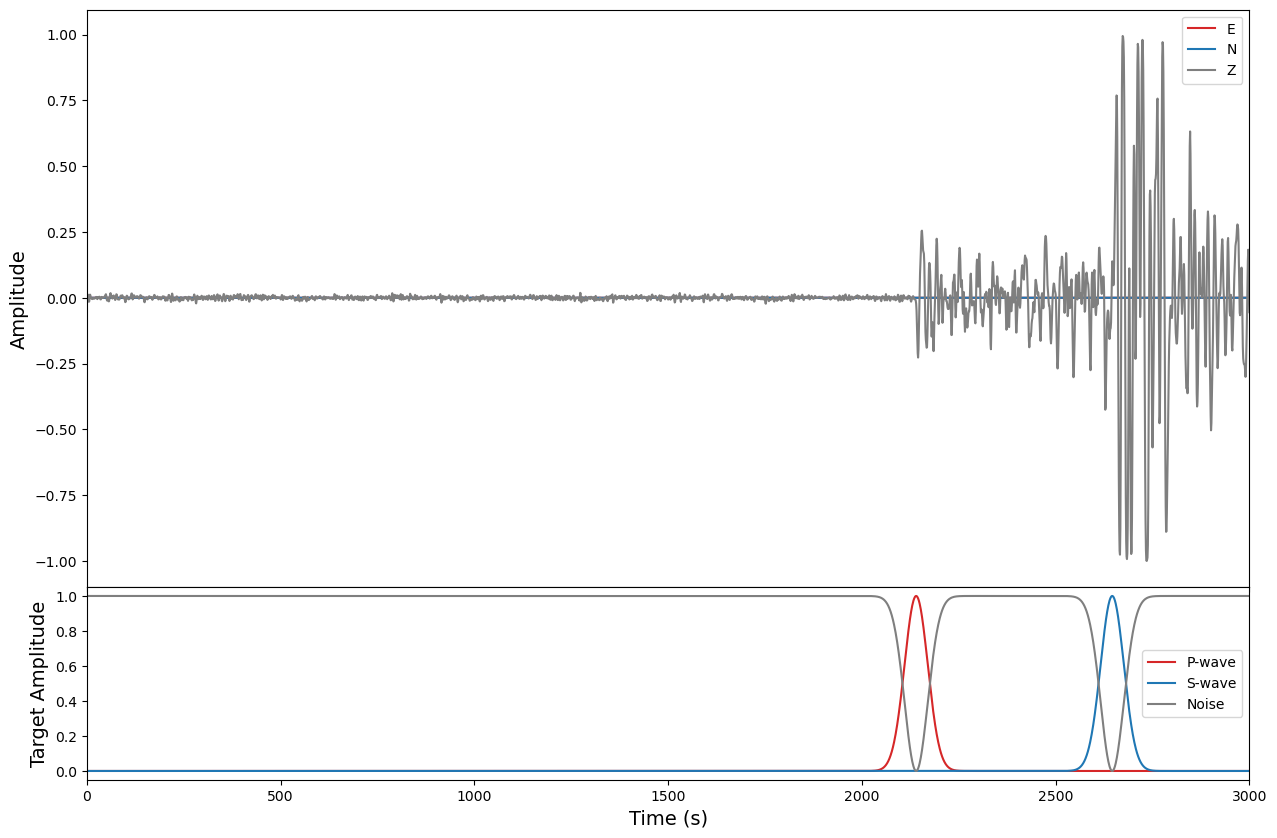

In [10]:
sample_id = 4
sample = test_generator[sample_id]
# Plot timeseries
fig = plt.figure(figsize=(15, 10))
axs = fig.subplots(2, 1, sharex=True, gridspec_kw={"hspace": 0, "height_ratios": [3, 1]})
axs[0].plot(sample["X"][0].T,label='E',color="tab:red")
axs[0].plot(sample["X"][1].T,label='N',color="tab:blue")
axs[0].plot(sample["X"][2].T,label='Z',color="tab:grey")
axs[0].legend()
axs[1].plot(sample["y"][0].T,label='P-wave',color="tab:red")
axs[1].plot(sample["y"][1].T,label='S-wave',color="tab:blue")
axs[1].plot(sample["y"][2].T,label='Noise',color="tab:grey")
axs[1].set_xlabel('Time (s)',fontsize=14)
axs[1].set_ylabel('Target Amplitude',fontsize=14)
axs[0].set_ylabel('Amplitude',fontsize=14)
axs[1].set_xlim((0,3000))
axs[1].legend()

# 4. Make test predictions

Next we make predictions on the test set.

/Users/amt/anaconda3/envs/pytorch/lib/python3.12/site-packages/seisbench/models/base.py:489: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_weights = torch.load(f"{path

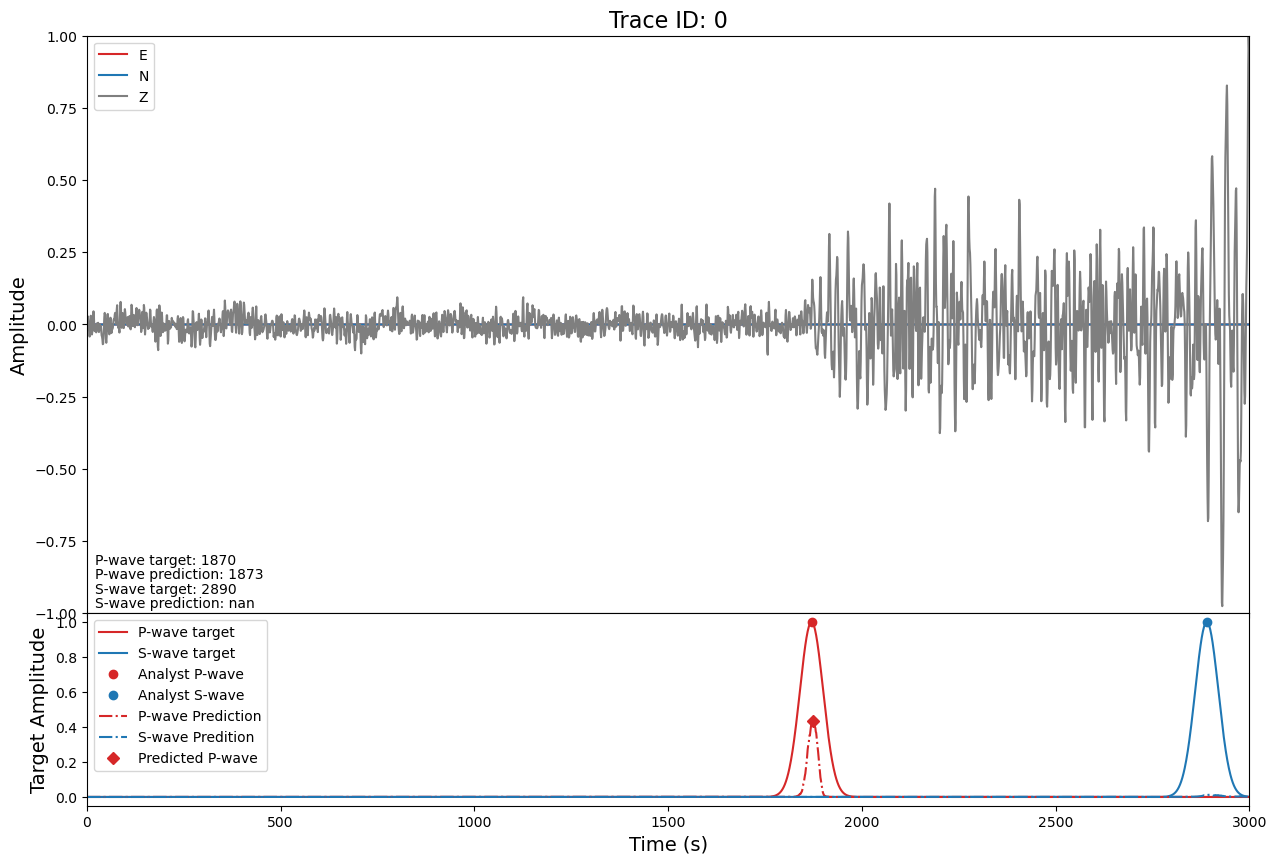

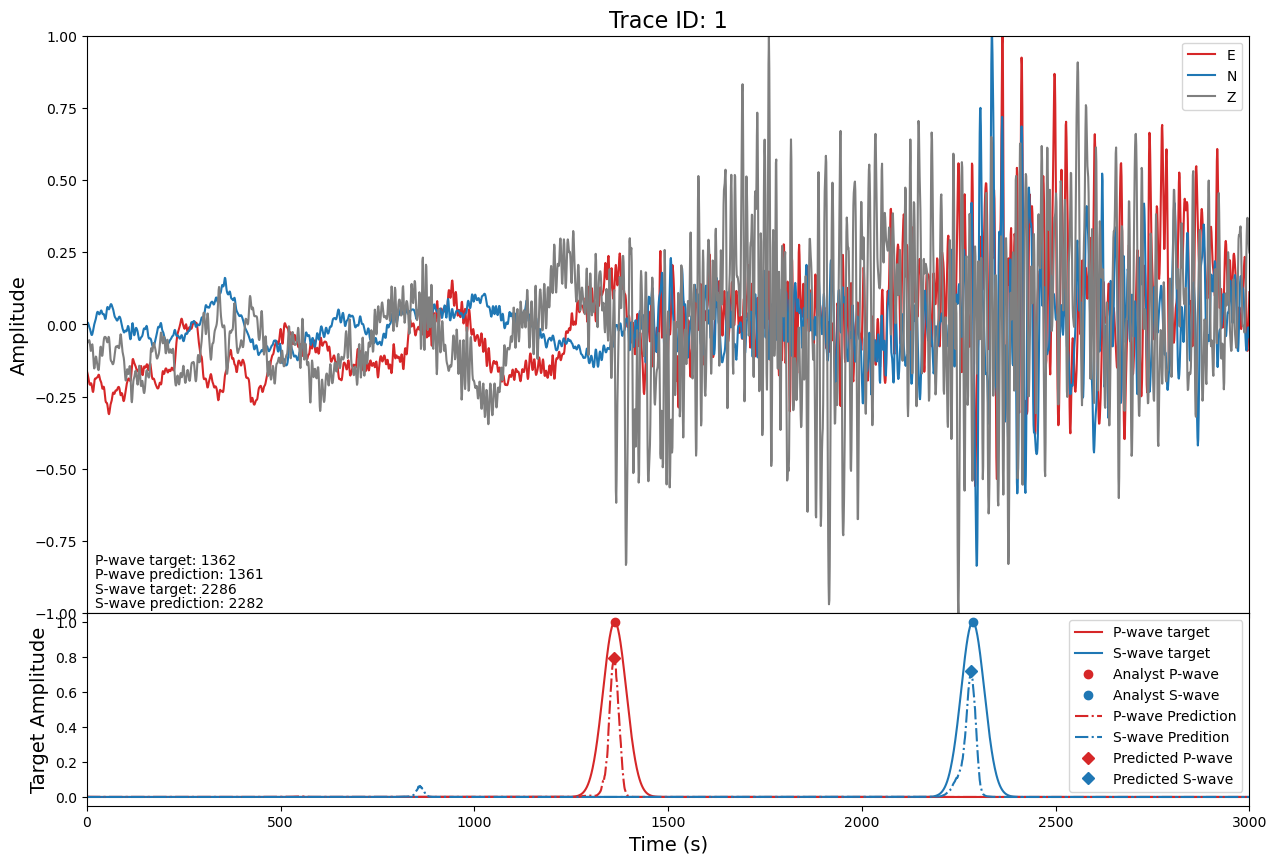

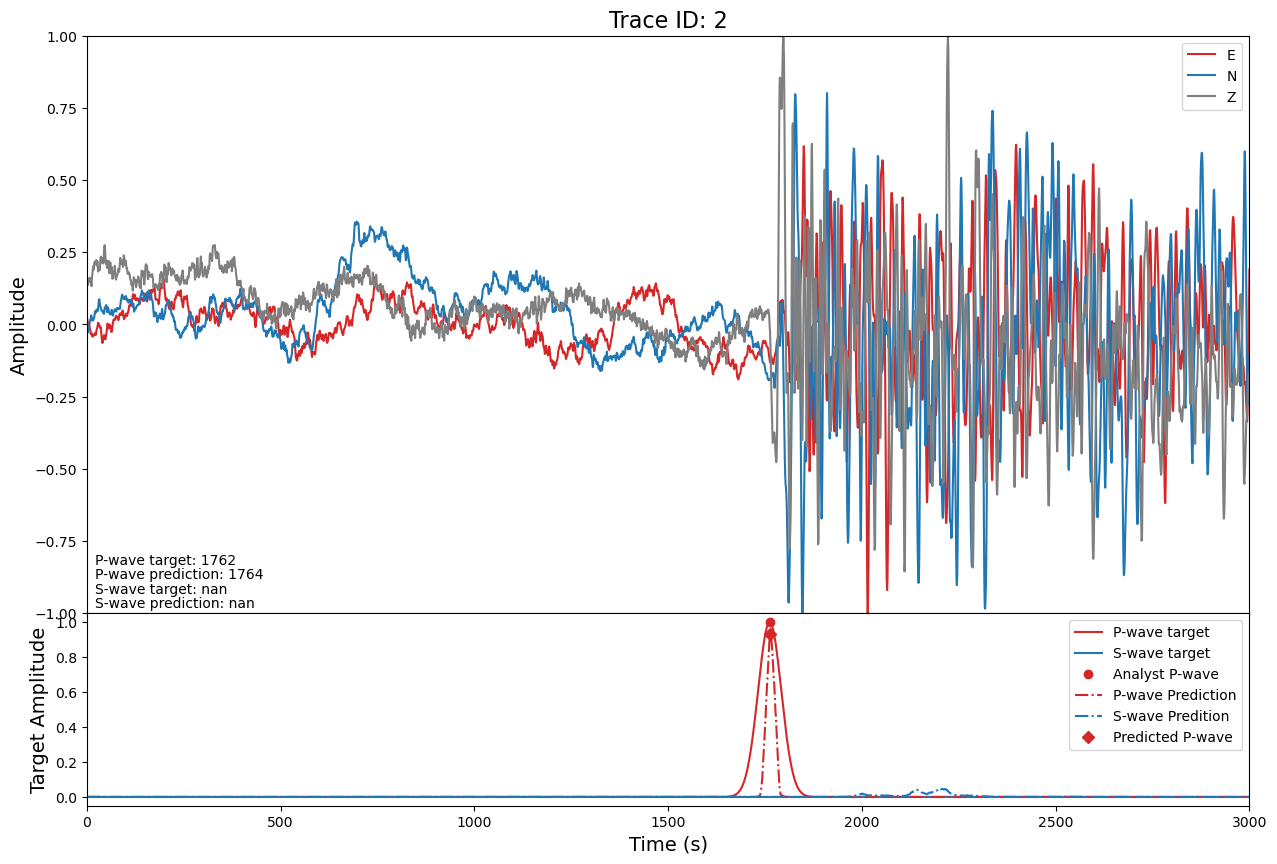

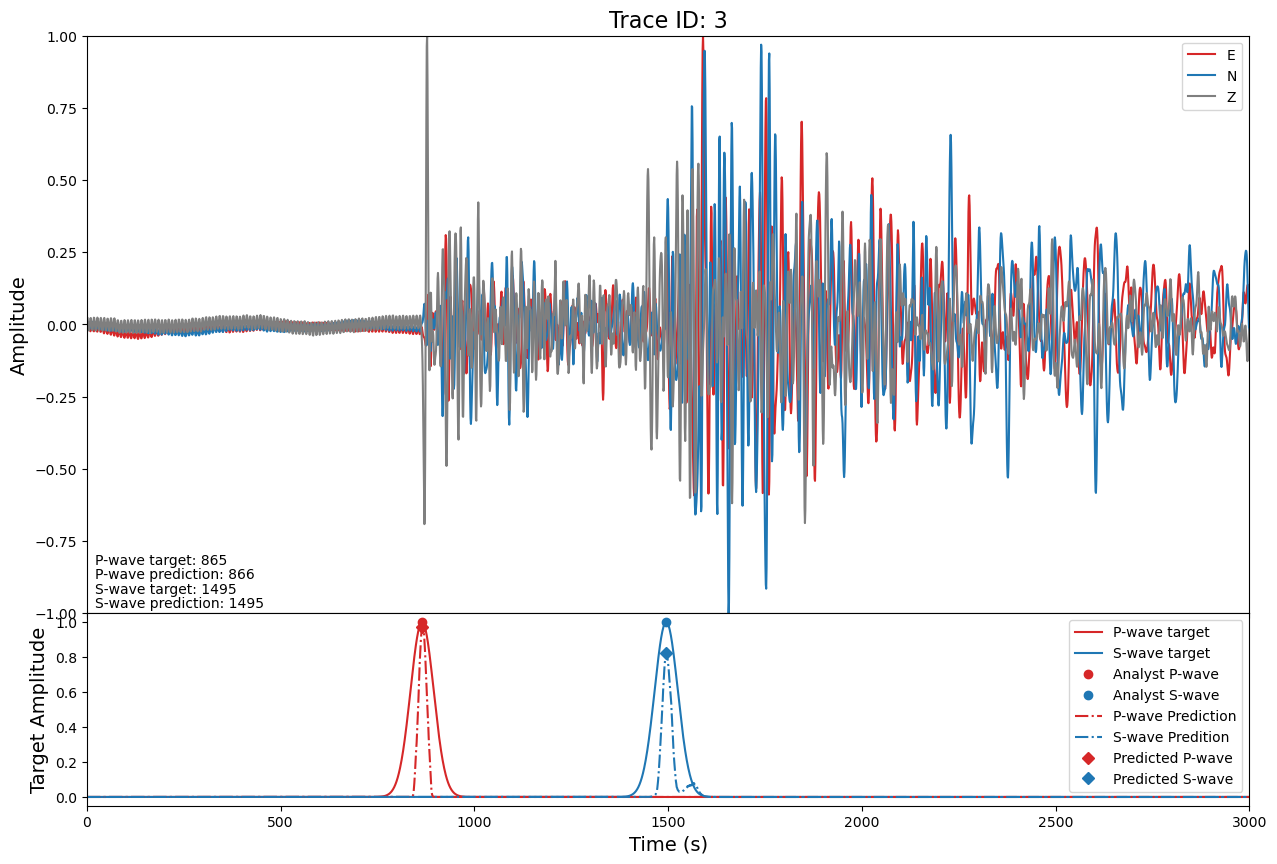

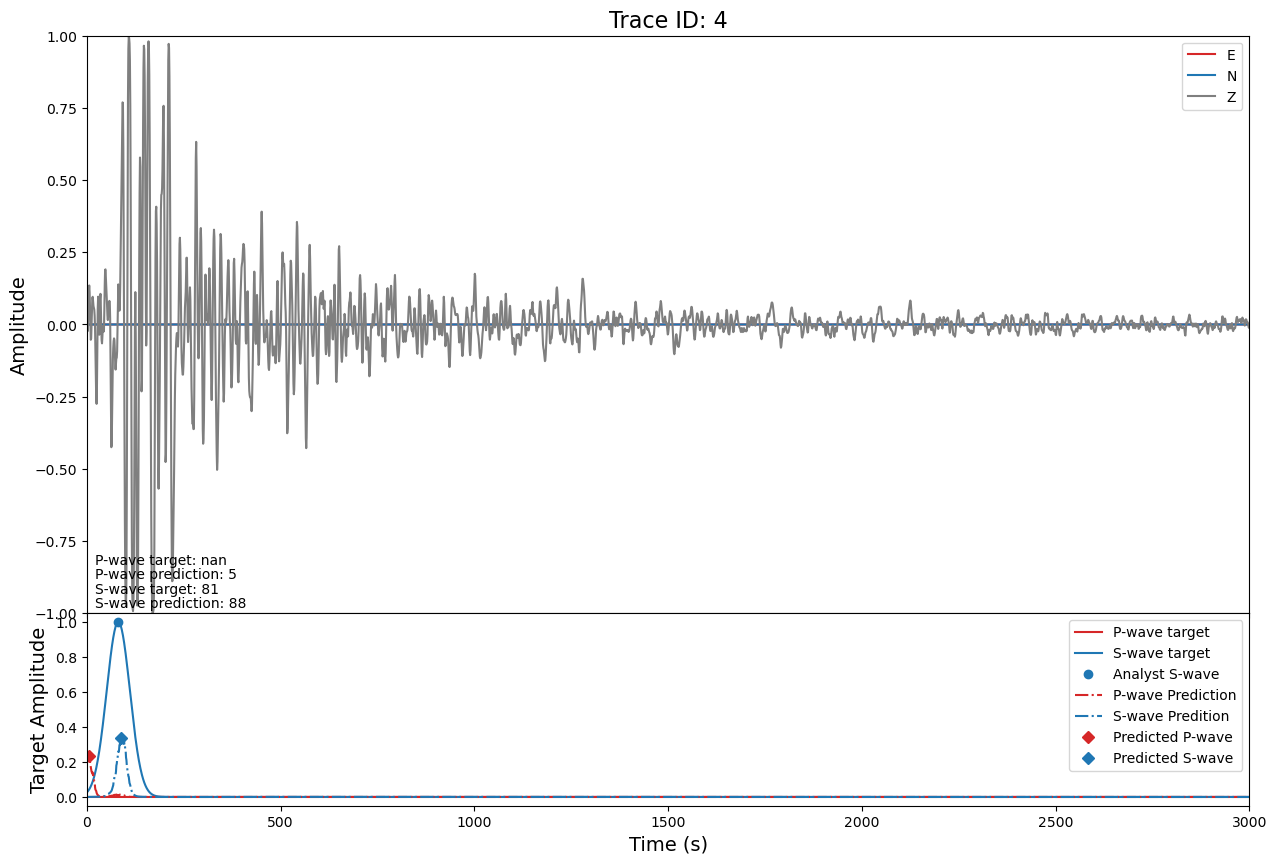

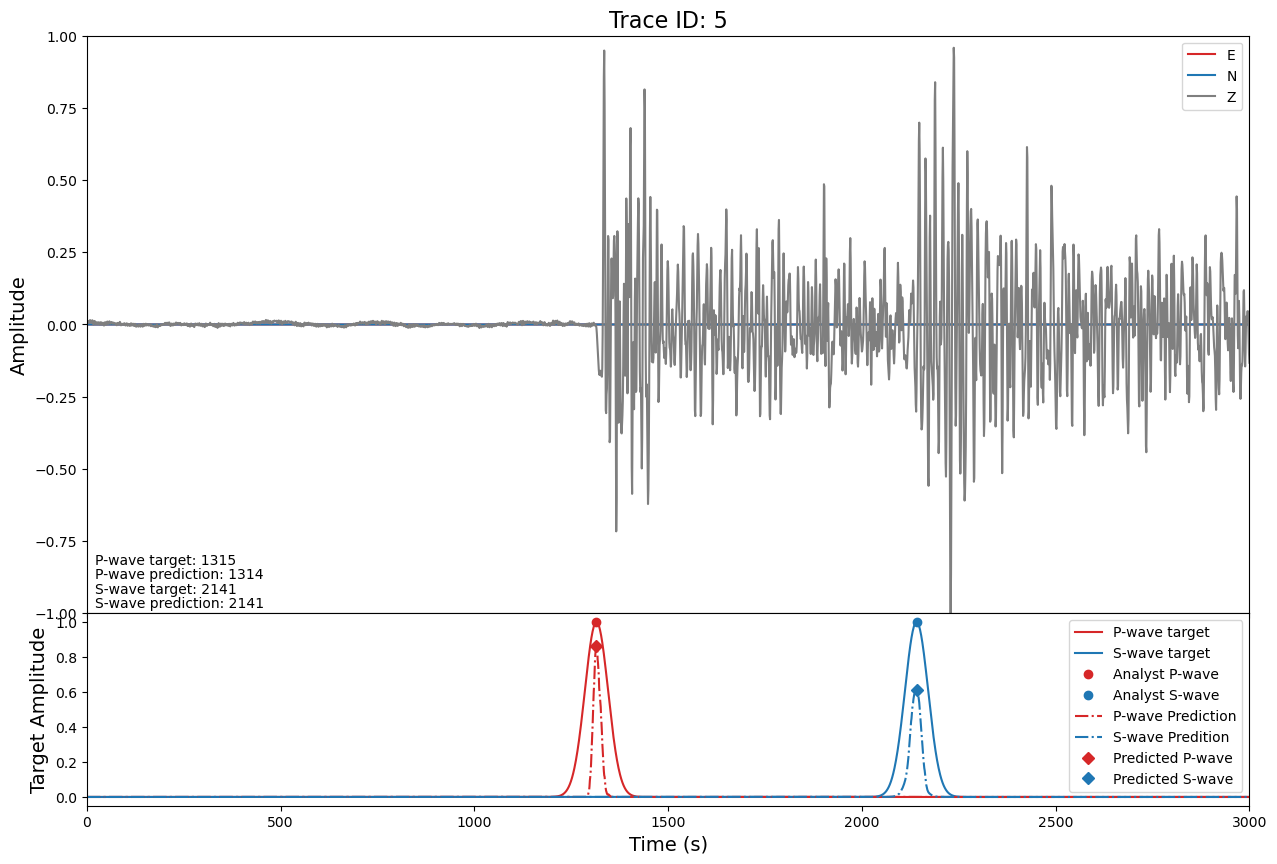

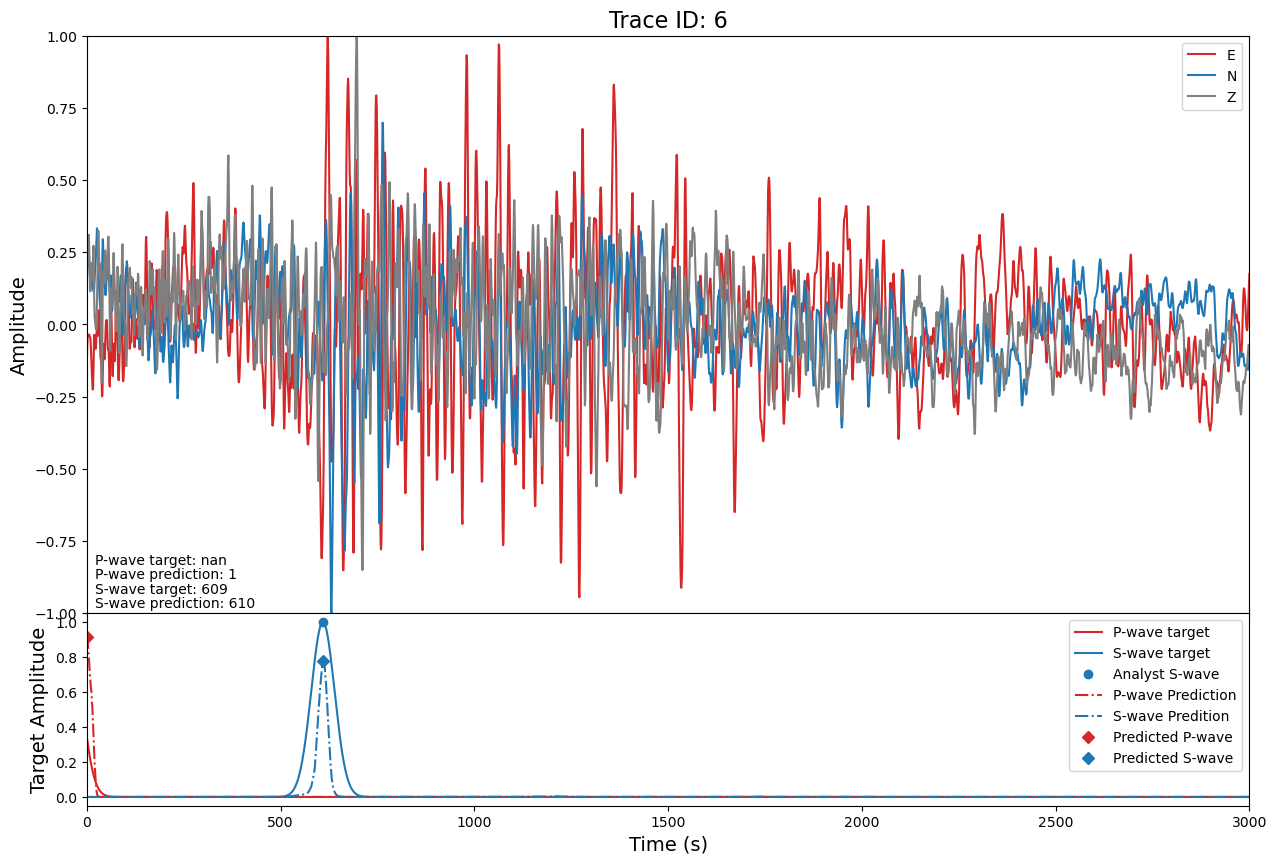

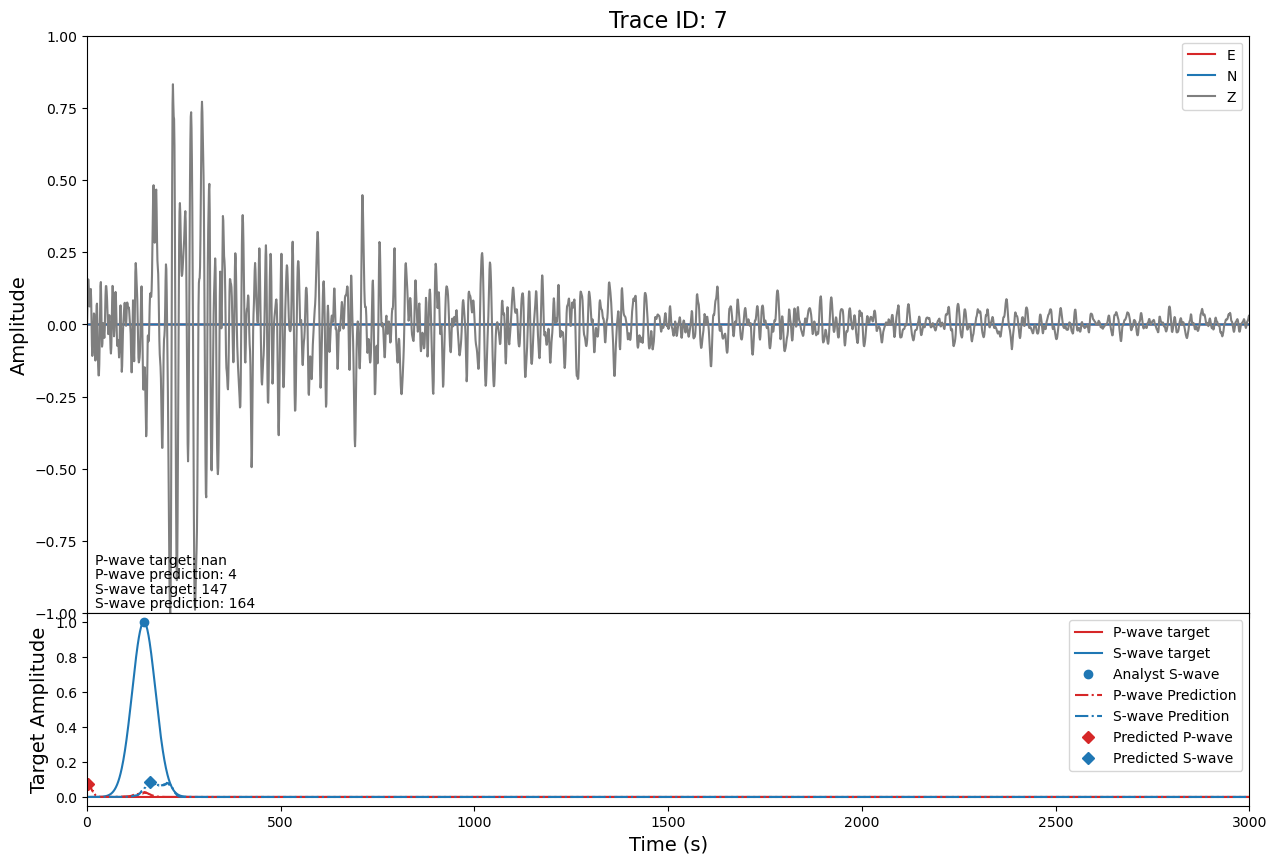

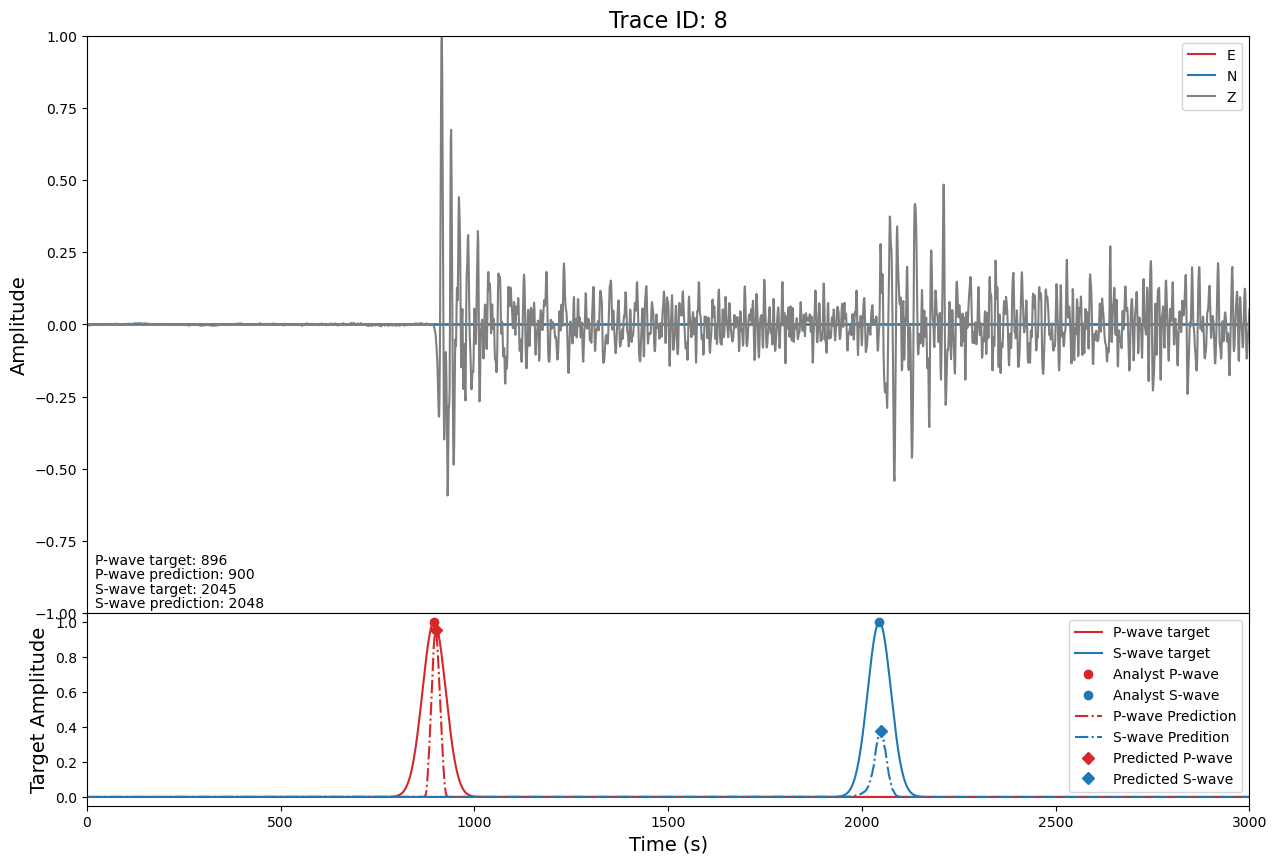

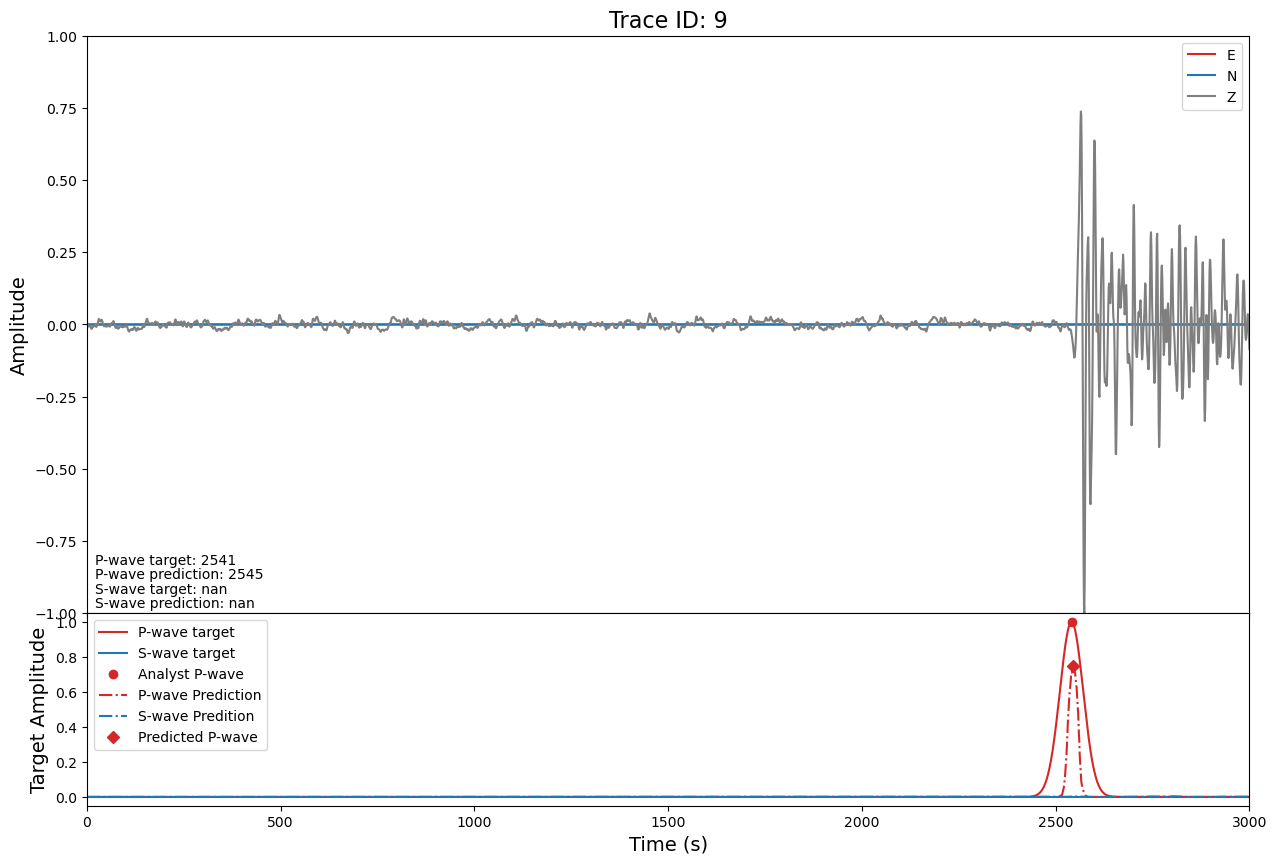

In [11]:
# seisbench prediction?
seisbench_pred=True
if seisbench_pred:
    pn_model = sbm.PhaseNet.from_pretrained("original")

# Define a lambda that returns the index of where the timeseries is maximum
def idx_max(ts):
    indices = np.where(ts == np.max(ts))[0]
    return indices[0], ts[indices[0]]

# Generate augmented samples and log their stats
targets =[]
predictions = []
for ii in range(len(test)):
    # Initialize variables
    p_idx_max, p_val_max, s_idx_max, s_val_max, p_pred_idx_max, s_pred_idx_max, largest_ppeak_idx, largest_speak_idx = -1, -1, -1, -1, -1, -1, -1, -1
    # Get the sample
    sample = test_generator[ii]
    if seisbench_pred:
        st=Stream()
        for cc, ch in enumerate(['E', 'N', 'Z']):
            trace = Trace(data=np.pad(sample['X'][cc], (250, 250), mode='constant', constant_values=0))
            trace.stats.sampling_rate = 100
            trace.stats.channel = ch
            st += trace
        preds = pn_model.annotate(st)
        noise_pred = preds[0].data
        p_pred = preds[1].data
        s_pred = preds[2].data
    else:
        with torch.no_grad():
            pred = model(torch.tensor(sample["X"], device=torch.device('cpu')).unsqueeze(0))  # Add a fake batch dimension
            p_pred, s_pred, noise_pred = pred[0].cpu().numpy()

    # Find the index of the maximum value in the analyist target
    p_idx_max, p_val_max = idx_max(sample["y"][0])
    s_idx_max, s_val_max = idx_max(sample["y"][1])

    # Find the index of the maximum value in the prediction
    p_pred_idx_max, _ = find_peaks(p_pred, height=0.05, distance=100) 
    s_pred_idx_max, _ = find_peaks(s_pred, height=0.05, distance=100) 

    # ------------ There is a P-wave prediction and a P-wave target ------------ 
    if len(p_pred_idx_max) > 0 and p_val_max == 1:
        largest_ppeak_idx = p_pred_idx_max[np.argmax(p_pred[p_pred_idx_max])]
        predictions.append({"trace_id": ii,
                    "pred_max_idx": largest_ppeak_idx, 
                    "pred_val": p_pred[largest_ppeak_idx],
                    "phase": "P"})         
        targets.append({"trace_id": ii,
                        "max_idx": p_idx_max,
                        "phase": "P"})
    # There is a P-wave prediction and no P-wave target --> false positive > dt / true negative if < dt
    elif len(p_pred_idx_max) > 0 and p_val_max != 1:    
        largest_ppeak_idx = p_pred_idx_max[np.argmax(p_pred[p_pred_idx_max])]
        predictions.append({"trace_id": ii,
                    "pred_max_idx": largest_ppeak_idx, 
                    "pred_val": p_pred[largest_ppeak_idx],
                    "phase": "P"})         
        targets.append({"trace_id": ii,
                        "max_idx": np.nan,
                        "phase": "P"})
    # There is no P-wave prediction and a P-wave target --> false negative
    elif len(p_pred_idx_max) == 0 and p_val_max == 1:
        predictions.append({"trace_id": ii,
                    "pred_max_idx": np.nan, 
                    "pred_val": np.nan,
                    "phase": "P"})         
        targets.append({"trace_id": ii,
                        "max_idx": p_idx_max,
                        "phase": "P"})
    # There is no P-wave prediction and no P-wave target --> true negative
    else:
        predictions.append({"trace_id": ii,
                    "pred_max_idx": np.nan, 
                    "pred_val": np.nan,
                    "phase": "P"})         
        targets.append({"trace_id": ii,
                        "max_idx": np.nan,
                        "phase": "P"})
        
    # ------------  There is a S-wave prediction and a S-wave target ------------ 
    if len(s_pred_idx_max) > 0 and s_val_max == 1:
        targets.append({"trace_id": ii,
                        "max_idx": s_idx_max,
                        "phase": "S"})
        largest_speak_idx = s_pred_idx_max[np.argmax(s_pred[s_pred_idx_max])]
        predictions.append({"trace_id": ii,
                    "pred_max_idx": largest_speak_idx, 
                    "pred_val": s_pred[largest_speak_idx],
                    "phase": "S"})
    # There is a S-wave prediction and no S-wave target --> false positive > dt / true negative if < dt
    elif len(s_pred_idx_max) > 0 and s_val_max != 1:    
        largest_speak_idx = s_pred_idx_max[np.argmax(s_pred[s_pred_idx_max])]
        predictions.append({"trace_id": ii,
                    "pred_max_idx": largest_speak_idx, 
                    "pred_val": s_pred[largest_speak_idx],
                    "phase": "S"})         
        targets.append({"trace_id": ii,
                        "max_idx": np.nan,
                        "phase": "S"})
    # There is no S-wave prediction and a S-wave target --> false negative
    elif len(s_pred_idx_max) == 0 and s_val_max == 1:
        predictions.append({"trace_id": ii,
                    "pred_max_idx": np.nan, 
                    "pred_val": np.nan,
                    "phase": "S"})         
        targets.append({"trace_id": ii,
                        "max_idx": s_idx_max,
                        "phase": "S"})
    # There is no S-wave prediction and no S-wave target --> true negative
    else:
        predictions.append({"trace_id": ii,
                    "pred_max_idx": np.nan, 
                    "pred_val": np.nan,
                    "phase": "S"})         
        targets.append({"trace_id": ii,
                        "max_idx": np.nan,
                        "phase": "S"})

    # Plot some examples
    if ii<10:
        # Plot waveforms
        fig = plt.figure(figsize=(15, 10))
        axs = fig.subplots(2, 1, sharex=True, gridspec_kw={"hspace": 0, "height_ratios": [3, 1]})
        axs[0].plot(sample["X"][0].T,label='E',color="tab:red")
        axs[0].plot(sample["X"][1].T,label='N',color="tab:blue")
        axs[0].plot(sample["X"][2].T,label='Z',color="tab:grey")
        axs[0].text(20,-0.83, f"P-wave target: {targets[-2]["max_idx"]}", fontsize=10)
        axs[0].text(20,-0.88, f"P-wave prediction: {predictions[-2]["pred_max_idx"]}", fontsize=10)
        axs[0].text(20,-0.93, f"S-wave target: {targets[-1]["max_idx"]}", fontsize=10)
        axs[0].text(20,-0.98, f"S-wave prediction: {predictions[-1]["pred_max_idx"]}", fontsize=10)
        axs[0].set_ylim((-1,1))
        # Plot target timeseries
        axs[1].plot(sample["y"][0].T,label='P-wave target', color="tab:red")
        axs[1].plot(sample["y"][1].T,label='S-wave target', color='tab:blue')
        if p_val_max == 1:
            axs[1].plot(targets[-2]["max_idx"], sample["y"][0][targets[-2]["max_idx"]], 'o', label='Analyst P-wave', color="tab:red")
        if s_val_max == 1:
            axs[1].plot(targets[-1]["max_idx"], sample["y"][1][targets[-1]["max_idx"]], 'o', label='Analyst S-wave', color='tab:blue')
        axs[1].plot(p_pred,label='P-wave Prediction', color="tab:red", linestyle='-.')
        axs[1].plot(s_pred,label='S-wave Predition', color='tab:blue', linestyle='-.')
        if largest_ppeak_idx > 0:
            axs[1].plot(predictions[-2]["pred_max_idx"],p_pred[predictions[-2]["pred_max_idx"]], 'D', label='Predicted P-wave', color="tab:red")
        if largest_speak_idx > 0:
            axs[1].plot(predictions[-1]["pred_max_idx"],s_pred[predictions[-1]["pred_max_idx"]], 'D', label='Predicted S-wave', color="tab:blue")
        axs[1].set_xlabel('Time (s)',fontsize=14)
        axs[1].set_ylabel('Target Amplitude',fontsize=14)
        axs[0].set_ylabel('Amplitude',fontsize=14)
        # axs[1].plot(noise_pred,label='Noise Prediction', color="tab:green", linestyle='-.')
        axs[1].legend()
        axs[0].legend()
        axs[0].set_xlim((0,3000))
        axs[1].set_xlim((0,3000))
        axs[0].set_title(f"Trace ID: {ii}", fontsize=16)

targets = pd.DataFrame(targets)
predictions = pd.DataFrame(predictions)

In [12]:
targets

,trace_id,max_idx,phase
0,0,1870.0,P
1,0,2890.0,S
2,1,1362.0,P
3,1,2286.0,S
4,2,1762.0,P
...,...,...,...
17935,8967,2031.0,S
17936,8968,809.0,P
17937,8968,1738.0,S
17938,8969,1506.0,P


In [13]:
predictions

,trace_id,pred_max_idx,pred_val,phase
0,0,1873.0,0.436259,P
1,0,NaN,NaN,S
2,1,1361.0,0.791852,P
3,1,2282.0,0.720918,S
4,2,1764.0,0.932841,P
...,...,...,...,...
17935,8967,2038.0,0.472659,S
17936,8968,813.0,0.908409,P
17937,8968,1738.0,0.755865,S
17938,8969,1511.0,0.946008,P


# 5.  Common Performance Metrics

## The Confusion Matrix

The confusion matrix is a tool used to evaluate the performance of a model. It provides insight into the model's performance, errors, and weaknesses which will allow us to further improve our model through fine-tuning.

<img src="https://github.com/amtseismo/2025_ML_TSC/blob/main/notebooks/Amanda/confusion_matrix.png?raw=true" width="800">

The four categories in the confusion matrix are:

- **True positive (TP)** - The model correctly (true) predicts the positive class (positive).
- **False positive (FP)** - The model incorrectly (false) predicts the positive class (positive).
- **False negative (FN)** - The model incorrectly (false) predicts the negative class (negative).
- **True negative (TN)** - The model correctly (true) predicts the negative class (negative).

Using these categories, there are multiple different metrics one can use to assess network perfomance.  For demonstration purposes, lets say we have a dataset of 100 seismograms.  5 of them contain earthquakes, and 95 of them contain noise.  Lets also say of the 5 earthquakes, the model correctly predicts 4 of them and misses 1.  For the 95 noise samples, the model correctly predicts 90 of them as noise and the other 5 it calls earthquakes.  In this scenario, TP = 4, TN = 90, FP = 5, FN = 1.

## Accuracy

Accuracy shows how often a model is correct overall.  It is defined as the total number of true predictions (i.e. TP + TN) divided by the total number of predictions.

$\huge Accuracy = \frac{TP + TN}{TP + FP + FN + TN} $

In our example above, TP + TN = 94 and the total number of predictions is 100 so we have 94% accuracy overall -- woo hoo!

Accuracy is widely used but its not always useful because it treats all classes as equally important. If a dataset is well balanced, meaning it has equal or nearly equal representation in the training data of all classes, accuracy can be a helpful metric. However, many real-world applications have a high imbalance of classes. These are the cases when one category has significantly more frequent occurrences than the other. In seismology, this would happen if you were to just estimate whether each section of a seismogram had an earthquake or recorded only noise. In scenarios like this, you are typically interested in predicting the events that rarely occur (i.e. earthquakes). It is easy to “game” the accuracy metric when making predictions for a dataset like this. To do that, you simply need to predict that every waveform is noise.  If only 5 in 100 waveforms actually contain an earthquake, a model predicting noise all the time will mostly be right, leading to very high accuracy.  In this particular situaion, your model would be 95% accurate however you'd miss every earthquake -- so high accuracy models can be useless. Overall accuracy is informative but using this metric alone is not advisable.

## Precision

Precision is a metric that measures how often a machine learning model is correct when it predicts the positive class (in our case, earthquakes). You can calculate precision by dividing the number of true positive predictions (TPs) by the total number of instances the model predicted as positive (TP + FP).

$\huge Precision = \frac{TP}{TP + FP} $

In our example above, TP = 4 and FP = 5 so the precition is 4/9 or 44%.  

Precision works well for problems with imbalanced classes since it shows the model correctness in identifying the positive class.  It's important to note that precision does not consider false negatives meaning it does not account for the cases when we miss earthquakes.   

## Recall

Recall is a metric that measures how often a machine learning model correctly identifies positive instances (TP) from all the actual positive samples in the dataset (TP + FN). 

$\huge Recall = \frac{TP}{TP + FN} $

From our example above, TP = 4 and FN = 1, so our recall is 4/5 or 80%.

Recall works well for problems with imbalanced classes since it is focused on the model’s ability to find earthquakes.  Recall is useful when the cost of false negatives is high. In this case, you typically want to find all earthquakes, even if this results in some false positives (predicting an earthquake when it is actually noise).  A downside is that recall does not account for the cost of these false positives.

## F1 score

If precision is high but recall is low, it means you're cautious and only pick when confident — but miss many real picks.  If recall is high but precision is low, it means you're aggressive, finding most real picks — but also making lots of false ones.  The F1 score is a metric that combines precision and recall into a single number. It’s especially useful when you want a balance between these two, particularly in imbalanced datasets — like seismic phase picking, where picks are rare compared to the number of time steps.

$\huge F1 = \frac{2*precision*recall}{precision + recall}$

F1 gives a harmonic mean, so it heavily penalizes large gaps between precision and recall.

# 6. Compute UNet Performance metrics

Looking back at the original Zhu and Beroza [2019] paper that introduced PhaseNet, they have a little bit of a problem.  They've set up the earthquake detection problem as a regression where the network outputs a "probability" between 0 and 1 to identify noise (0) vs. a phase arrival (1).  So how do we translate this into a classicifcation problem so that we can use the swanky metrics we introduced above?  Well they did it as follows (and so will we!):

- **True positive** - peak amplitude is above decision threshold and < 0.1s from true arrival
- **False positive** - peak amplitude is above decision threshold and >= 0.1s from true arrival
- **False negative** - peak amplitude is below decision threshold and < 0.1s from true arrival
- **True negative** - peak amplitude is below decision threshold and >= 0.1s

This next block includes masks that deal with missing targets or predictions.

In [14]:
merged = pd.merge(
    predictions, 
    targets, 
    how="inner", 
    on=["trace_id", "phase"],
    suffixes=('_pred', '_true')
)

# Delete for speed
del predictions
del targets

# Dealing with the NaNs
mask=False
if mask:
    no_pred_and_no_target = (
        merged["pred_max_idx"].isna() & 
        merged["max_idx"].isna() & 
        merged["pred_val"].isna()
    )

    target_no_pred = (
        merged["pred_max_idx"].isna() & 
        merged["max_idx"].notna() & 
        merged["pred_val"].isna()
    )

    pred_no_target = (
        merged["pred_max_idx"].notna() & 
        merged["max_idx"].isna() & 
        merged["pred_val"].notna()
    )

    # Apply masks
    merged.loc[no_pred_and_no_target, ["pred_max_idx", "max_idx", "pred_val"]] = [0, 100, 0]
    merged.loc[target_no_pred, ["pred_max_idx", "max_idx", "pred_val"]] = [0, 0, 0]
    merged.loc[pred_no_target, ["pred_max_idx", "max_idx"]] = [0, 100]
else:
    merged=merged.dropna()

with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(merged)

# Check for NaN values in the merged DataFrame
merged[merged.isna().any(axis=1)]

       trace_id  pred_max_idx  pred_val phase  max_idx
0             0        1873.0  0.436259     P   1870.0
2             1        1361.0  0.791852     P   1362.0
3             1        2282.0  0.720918     S   2286.0
4             2        1764.0  0.932841     P   1762.0
6             3         866.0  0.971795     P    865.0
7             3        1495.0  0.822210     S   1495.0
9             4          88.0  0.334481     S     81.0
10            5        1314.0  0.864006     P   1315.0
11            5        2141.0  0.608934     S   2141.0
13            6         610.0  0.777767     S    609.0
15            7         164.0  0.082916     S    147.0
16            8         900.0  0.952481     P    896.0
17            8        2048.0  0.378576     S   2045.0
18            9        2545.0  0.748032     P   2541.0
21           10         711.0  0.654785     S    700.0
22           11        2528.0  0.876624     P   2526.0
24           12         957.0  0.931530     P    953.0
25        

,trace_id,pred_max_idx,pred_val,phase,max_idx


In [15]:
decision_thresholds = np.linspace(0.05, 0.95, num=19)
pprecision = np.zeros(len(decision_thresholds))
precall = np.zeros(len(decision_thresholds))
sprecision = np.zeros(len(decision_thresholds))
srecall = np.zeros(len(decision_thresholds))

for phase in ["P", "S"]:
    phase_data = merged[merged["phase"] == phase]
    for ii, decision_threshold in enumerate(decision_thresholds):
        above_thresh = phase_data["pred_val"] >= decision_threshold
        close_enough = (phase_data["pred_max_idx"] - phase_data["max_idx"]).abs() < 10

        TP = ((above_thresh) & (close_enough)).sum()
        FP = ((above_thresh) & (~close_enough)).sum()
        FN = ((~above_thresh) & (close_enough)).sum()
        TN = ((~above_thresh) & (~close_enough)).sum()

        # Save or print results here as before  
        print(f"Decision Threshold: {decision_threshold}, TP: {TP}, FP: {FP}, FN: {FN}, TN: {TN}, Total: {TN+FN+TP+FP}")

        if phase == "P":
            pprecision[ii] = TP / (TP + FP) if (TP + FP) > 0 else 0
            precall[ii] = TP / (TP + FN) if (TP + FN) > 0 else 0
        elif phase == "S":
            sprecision[ii] = TP / (TP + FP) if (TP + FP) > 0 else 0
            srecall[ii] = TP / (TP + FN) if (TP + FN) > 0 else 0

pF1=2*pprecision*precall/(pprecision+precall)
sF1=2*sprecision*srecall/(sprecision+srecall)

Decision Threshold: 0.05, TP: 5116, FP: 710, FN: 0, TN: 0, Total: 5826
Decision Threshold: 0.1, TP: 4940, FP: 638, FN: 176, TN: 72, Total: 5826
Decision Threshold: 0.15, TP: 4795, FP: 585, FN: 321, TN: 125, Total: 5826
Decision Threshold: 0.2, TP: 4642, FP: 542, FN: 474, TN: 168, Total: 5826
Decision Threshold: 0.25, TP: 4510, FP: 499, FN: 606, TN: 211, Total: 5826
Decision Threshold: 0.3, TP: 4366, FP: 471, FN: 750, TN: 239, Total: 5826
Decision Threshold: 0.35, TP: 4241, FP: 439, FN: 875, TN: 271, Total: 5826
Decision Threshold: 0.39999999999999997, TP: 4087, FP: 406, FN: 1029, TN: 304, Total: 5826
Decision Threshold: 0.44999999999999996, TP: 3885, FP: 376, FN: 1231, TN: 334, Total: 5826
Decision Threshold: 0.49999999999999994, TP: 3529, FP: 348, FN: 1587, TN: 362, Total: 5826
Decision Threshold: 0.5499999999999999, TP: 3316, FP: 327, FN: 1800, TN: 383, Total: 5826
Decision Threshold: 0.6, TP: 3139, FP: 302, FN: 1977, TN: 408, Total: 5826
Decision Threshold: 0.65, TP: 2989, FP: 278, 

# 7. Plot precision, recall, and F1

P Precision = 0.9102398761929327
P Recall = 0.6897967161845192
S Precision = 0.8651439299123905
S Recall = 0.5727009113504556


<Figure size 640x480 with 0 Axes>

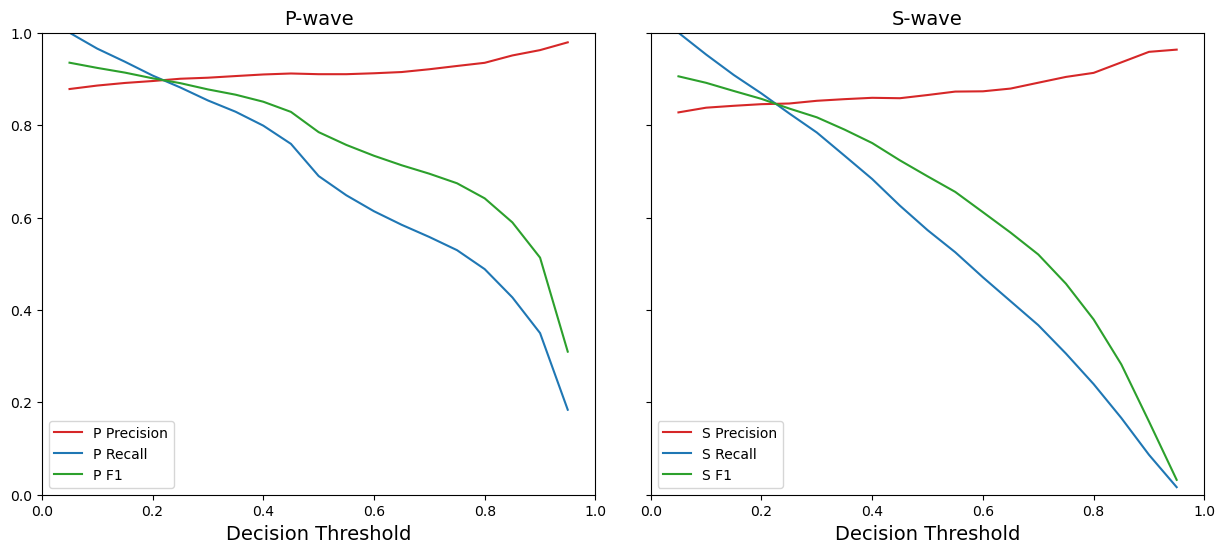

In [16]:
fig = plt.figure()
fig, axs = plt.subplots(
    1, 2,              # 1 row, 2 columns
    figsize=(15, 6),  # overall figure size
    sharey=True,       # share y-axis
    gridspec_kw={"width_ratios": [1, 1], "wspace": 0.1}  # control layout
)
decision_thresholds = np.linspace(0.05, 0.95, num=19)
axs[0].plot(decision_thresholds, pprecision, label='P Precision', color="tab:red")
axs[0].plot(decision_thresholds, precall, label='P Recall', color="tab:blue")
axs[0].plot(decision_thresholds, pF1, label='P F1', color="tab:green")
axs[0].set_xlim(0,1)
axs[0].set_ylim(0,1)
axs[0].legend()
axs[0].set_title("P-wave", fontsize=14)
axs[1].set_title("S-wave", fontsize=14)
axs[1].plot(decision_thresholds, sprecision, label='S Precision', color="tab:red")
axs[1].plot(decision_thresholds, srecall, label='S Recall', color="tab:blue")
axs[1].plot(decision_thresholds, sF1, label='S F1', color="tab:green")
axs[1].set_xlim(0,1)
axs[1].set_ylim(0,1)
axs[0].set_xlabel('Decision Threshold', fontsize=14)
axs[1].set_xlabel('Decision Threshold', fontsize=14)
axs[1].legend()

ind=9
print("P Precision = "+str(pprecision[ind]))
print("P Recall = "+str(precall[ind]))
print("S Precision = "+str(sprecision[ind]))
print("S Recall = "+str(srecall[ind]))

from IPython.display import Image, display
display(Image(filename='./table1.png'))

For reference here are the specs from the original PhaseNet paper.  How do they compare?

<img src="https://github.com/amtseismo/2025_ML_TSC/blob/main/notebooks/Amanda/table1.png?raw=true" width="800">

# 8. Compute and plot the pick distribution

Text(0.5, 0, 'Residual [samples]')

<Figure size 640x480 with 0 Axes>

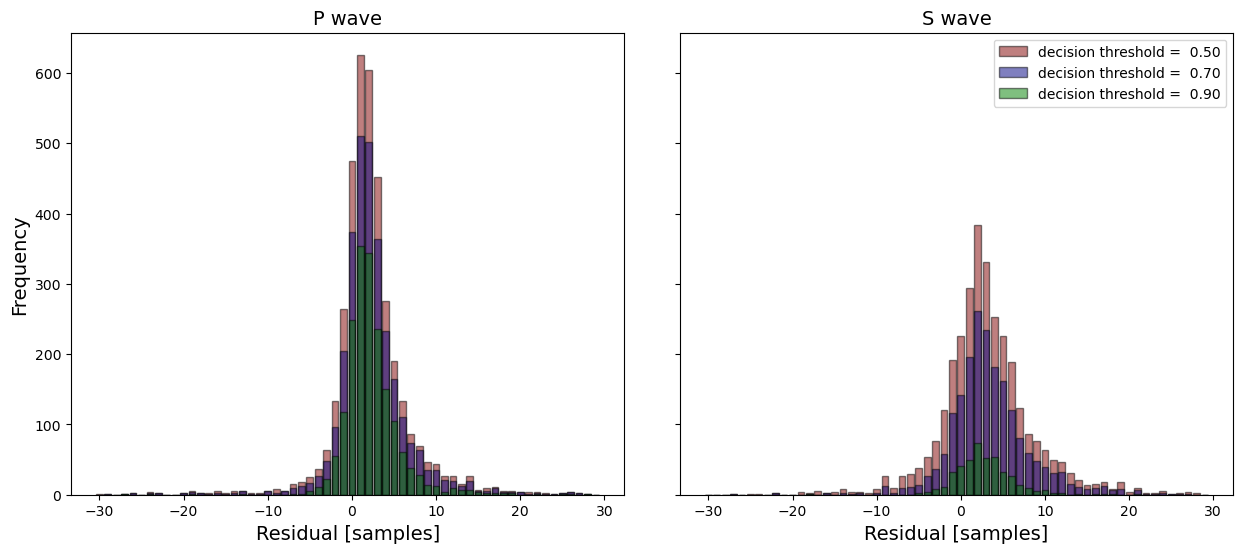

In [17]:
decision_thresholds=[0.5,0.7,0.9]

# Plot the histograms
colors = [[0.5,0,0],[0,0,0.5],[0,0.5,0]]
fig = plt.figure()
fig, axs = plt.subplots(
    1, 2,              # 1 row, 2 columns
    figsize=(15, 6),  # overall figure size
    sharey=True,       # share y-axis
    gridspec_kw={"width_ratios": [1, 1], "wspace": 0.1}  # control layout
)

for count, decision_threshold in enumerate(decision_thresholds):
    # Decision threshold
    phase="P"
    phase_data = merged[(merged["phase"] == phase) & (merged["pred_val"] >= decision_threshold) & (merged["max_idx"] != -100)]
    p_pick_diff = phase_data["pred_max_idx"] - phase_data["max_idx"]
    phase="S"
    phase_data = merged[(merged["phase"] == phase) & (merged["pred_val"] >= decision_threshold) & (merged["max_idx"] != -100)]
    s_pick_diff = phase_data["pred_max_idx"] - phase_data["max_idx"]

    axs[0].hist(p_pick_diff, bins=np.arange(-30.5,30.5,1), rwidth=0.8, color=colors[count], alpha=0.5, edgecolor='black', label="decision threshold ="+'% 6.2f' % decision_threshold)
    axs[1].hist(s_pick_diff, bins=np.arange(-30.5,30.5,1), rwidth=0.8, color=colors[count], alpha=0.5, edgecolor='black', label="decision threshold ="+'% 6.2f' % decision_threshold)
plt.legend()
axs[0].set_xlabel("Residual [samples]",fontsize=14)
axs[0].set_title("P wave",fontsize=14)
axs[1].set_title("S wave",fontsize=14)
axs[0].set_ylabel("Frequency",fontsize=14)
axs[1].set_xlabel("Residual [samples]",fontsize=14)

We will leave it as an exercise for the reader compute the mean and standard deviation of the residuals (t < 0.5 s) whose distributions are shown above and compare those to the values reported in table 1.  

# 9. Other metrics?

In some cases performance metrics are straightforward and in other cases they are subjective.  The onus is on the researcher to select or design appropriate metrics.

## References

* Zhu, W., & Beroza, G. C. (2019). PhaseNet: A deep-neural-network-based seismic arrival-time picking method. *Geophysical Journal International*, 216(1), 261–273. https://doi.org/10.1093/gji/ggy423
